## Mount Google Drive and prepare dataset
 Firstly we mount Google Drive, copy the dataset zip into the Colab runtime, extract it, and set the dataset path.

In [ ]:
# Import the 'drive' module from Google Colab to access Google Drive
from google.colab import drive

# Mount Google Drive to the Colab environment at the specified path
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Copy the dataset ZIP file from Google Drive to the local environment
!cp "/content/drive/My Drive/FYP_Project/CBIS_DDSM.zip" .
# Unzip the dataset quietly (suppress output)
!unzip -qq CBIS_DDSM.zip
# Remove the ZIP file after extraction to save storage space
!rm CBIS_DDSM.zip
# Set the dataset directory path
cbis_path = 'CBIS_DDSM'


# Install dependencies
We install TensorFlow (quiet mode) and import required libraries.

In [ ]:
# Install TensorFlow for model training
!pip install tensorflow -qq

In [ ]:
# Import all necessary Libraries
import os
import numpy as np
import statistics
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load and preprocess test set
 - Loads `.npy` arrays of test images and labels  
 - Remaps labels to binary (0 = mass, 1 = calcification)  
 - Prepares both grayscale and VGG-compatible 3-channel versions of images

In [ ]:
# Load and preprocess data
def load_testing_data():
    # Load the test set
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images,labels

def remap_label(l):
    # Remap the labels to 0->mass 1->calcification
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("Unrecognized label (%d)" % l)
        return None

# Load test images
test_images, test_labels= load_testing_data()
test_images_vgg, _ = load_testing_data()

# Remap test labels
test_labels = np.array([remap_label(l) for l in test_labels])

# Number of images
n_test_img = test_images.shape[0]

# Compute width and height of images
img_w = test_images.shape[1]
img_h = test_images.shape[2]

# Create a new dimension for color in the images arrays
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))
test_images_vgg = test_images_vgg.reshape((n_test_img, img_w, img_h, 1))

# Rescale values to (0-1), or (0-255) for VGG
test_images = test_images.astype('uint16') / 65535
test_images_vgg = test_images_vgg.astype('uint16') / 256

# Replicate the only channel 3 times for VGG16
test_images_vgg = np.repeat(test_images_vgg, 3, axis=3)

# Normalize VGG images
preprocess_input(test_images_vgg);

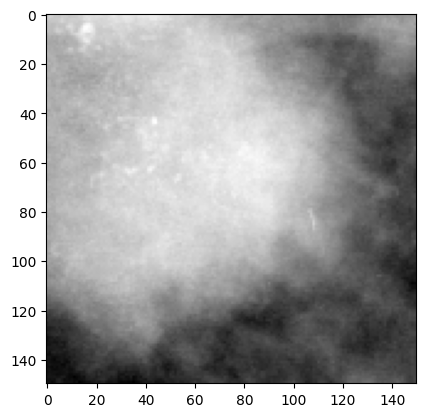

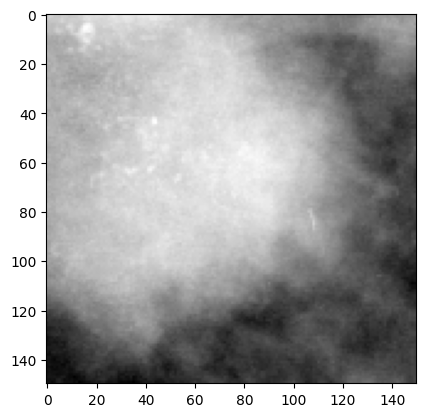

In [ ]:
# Visualize the first image
idx = 0

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.figure()

plt.imshow(test_images_vgg[idx][:,:,0]/256, cmap='gray')
plt.show()

# Load pre-trained models
Models were trained previously and saved in Google Drive.  
 We copy them into the Colab runtime and load them with `keras.models.load_model`.


In [ ]:
!cp "/content/drive/My Drive/FYP_Project/models/model_5_MC_best.keras" .
!cp "/content/drive/My Drive/FYP_Project/models/model_6_MC_best.keras" .
!cp "/content/drive/My Drive/FYP_Project/models/model_9_MC_best.keras" .
!cp "/content/drive/My Drive/FYP_Project/models/vgg16_ft_2layer_2cl_best.keras" .

model5 = models.load_model('model_5_MC_best.keras');
model6 = models.load_model('model_6_MC_best.keras');
model9 = models.load_model('model_9_MC_best.keras');
modelvgg = models.load_model('vgg16_ft_2layer_2cl_best.keras');

# Evaluate single-model performance
 Each model is tested on the preprocessed dataset.  
 - Custom CNNs → grayscale input  
 - VGG16 → 3-channel VGG input

In [ ]:
_, acc5 = model5.evaluate(test_images, test_labels, verbose=False)
_, acc6 = model6.evaluate(test_images, test_labels, verbose=False)
_, acc9 = model9.evaluate(test_images, test_labels, verbose=False)
_, accvgg = modelvgg.evaluate(test_images_vgg, test_labels, verbose=False)


# Ensemble 1: Models 5, 6, 9
 We compute predictions from three CNN models.  
 Two ensemble strategies are used:
 - **Majority voting** → select the class predicted by most models  
 - **Averaging** → mean of predicted outputs, then assign label

In [ ]:
ensemble1_cl = np.array([
    np.argmax(model5.predict(test_images), axis=-1).tolist(),
    np.argmax(model6.predict(test_images), axis=-1).tolist(),
    np.argmax(model9.predict(test_images), axis=-1).tolist()
])

ensemble1_pred = np.array([
    model5.predict(test_images).tolist(),
    model6.predict(test_images).tolist(),
    model9.predict(test_images).tolist()
])


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
# Accuracy by voting (majority voting)
ensemble1_voting_pred = np.array([
    statistics.mode([ensemble1_cl[m][e] for m in range(len(ensemble1_cl))])
    for e in range(n_test_img)
])

ensemble1_voting_right = sum([p == l for p, l in zip(ensemble1_voting_pred, test_labels)])
ensemble1_voting_acc = ensemble1_voting_right / n_test_img

# Accuracy by averaging (mean prediction)
ensemble1_avg_pred = np.array([
    np.mean([ensemble1_pred[m][e] for m in range(len(ensemble1_pred))])
    for e in range(n_test_img)
])

ensemble1_avg_right = sum([(abs(p - l) < 0.5) for p, l in zip(ensemble1_avg_pred, test_labels)])
ensemble1_avg_acc = ensemble1_avg_right / n_test_img

# Print results
print("\nM5")
print(ensemble1_cl[0])
print("Acc: %.4f" % acc5)
print("\nM6")
print(ensemble1_cl[1])
print("Acc: %.4f" % acc6)
print("\nM9")
print(ensemble1_cl[2])
print("Acc: %.4f" % acc9)
print("\nEnsemble (Voting)")
print(ensemble1_voting_pred)

print("Voting accuracy: %.4f" % ensemble1_voting_acc)
print("Averaging accuracy: %.4f" % ensemble1_avg_acc)



M5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Acc: 0.8185

M6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# Ensemble 2: Models 5, 6, 9, and VGG16 (double weight)
 This ensemble includes the VGG16 model twice, effectively giving it higher weight.

In [ ]:
ensemble2_cl = np.array([
    np.argmax(model5.predict(test_images), axis=-1).tolist(),  # Use np.argmax to get class labels
    np.argmax(model6.predict(test_images), axis=-1).tolist(),
    np.argmax(model9.predict(test_images), axis=-1).tolist(),
    np.argmax(modelvgg.predict(test_images_vgg), axis=-1).tolist(),
    np.argmax(modelvgg.predict(test_images_vgg), axis=-1).tolist()
])

# Get the predicted probabilities
ensemble2_pred = np.array([
    model5.predict(test_images).tolist(),  # Predict probabilities
    model6.predict(test_images).tolist(),
    model9.predict(test_images).tolist(),
    modelvgg.predict(test_images_vgg).tolist(),
    modelvgg.predict(test_images_vgg).tolist()
])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
# Accuracy by voting (majority voting)
ensemble1_voting_pred = np.array([
    statistics.mode([ensemble1_cl[m][e] for m in range(len(ensemble1_cl))])
    for e in range(n_test_img)
])

ensemble1_voting_right = sum([p == l for p, l in zip(ensemble1_voting_pred, test_labels)])
ensemble1_voting_acc = ensemble1_voting_right / n_test_img

# Accuracy by averaging (mean prediction)
ensemble1_avg_pred = np.array([
    np.mean([ensemble1_pred[m][e] for m in range(len(ensemble1_pred))])
    for e in range(n_test_img)
])

ensemble1_avg_right = sum([(abs(p - l) < 0.5) for p, l in zip(ensemble1_avg_pred, test_labels)])
ensemble1_avg_acc = ensemble1_avg_right / n_test_img

# Print results
print("\nM5")
print(ensemble1_cl[0])
print("Acc: %.4f" % acc5)
print("\nM6")
print(ensemble1_cl[1])
print("Acc: %.4f" % acc6)
print("\nM9")
print(ensemble1_cl[2])
print("Acc: %.4f" % acc9)
print("\nEnsemble (Voting)")
print(ensemble1_voting_pred)

print("Voting accuracy: %.4f" % ensemble1_voting_acc)
print("Averaging accuracy: %.4f" % ensemble1_avg_acc)



M5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Acc: 0.8185

M6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0